**IMPORTING ALL ESSENTIAL LIBRARIES**

In [1]:
# Import required libraries
from google.colab import files
import pandas as pd

**UPLOADING DATASET AND VIEWING LAST 5 ROWS**

In [2]:


# Upload the dataset
uploaded = files.upload()

# Load the dataset into a pandas DataFrame
# Assuming the uploaded file is in CSV format
for filename in uploaded.keys():
    data = pd.read_csv(filename)
    print(f"Dataset '{filename}' uploaded successfully!")

# Display the first few rows of the dataset to verify
data.head()


Saving bank_transactions_data_2.csv to bank_transactions_data_2.csv
Dataset 'bank_transactions_data_2.csv' uploaded successfully!


,TransactionID,AccountID,TransactionAmount,TransactionDate,TransactionType,Location,DeviceID,IP Address,MerchantID,Channel,CustomerAge,CustomerOccupation,TransactionDuration,LoginAttempts,AccountBalance,PreviousTransactionDate
0,TX000001,AC00128,14.09,2023-04-11 16:29:14,Debit,San Diego,D000380,162.198.218.92,M015,ATM,70,Doctor,81,1,5112.21,2024-11-04 08:08:08
1,TX000002,AC00455,376.24,2023-06-27 16:44:19,Debit,Houston,D000051,13.149.61.4,M052,ATM,68,Doctor,141,1,13758.91,2024-11-04 08:09:35
2,TX000003,AC00019,126.29,2023-07-10 18:16:08,Debit,Mesa,D000235,215.97.143.157,M009,Online,19,Student,56,1,1122.35,2024-11-04 08:07:04
3,TX000004,AC00070,184.50,2023-05-05 16:32:11,Debit,Raleigh,D000187,200.13.225.150,M002,Online,26,Student,25,1,8569.06,2024-11-04 08:09:06
4,TX000005,AC00411,13.45,2023-10-16 17:51:24,Credit,Atlanta,D000308,65.164.3.100,M091,Online,26,Student,198,1,7429.40,2024-11-04 08:06:39


**DATA PRE-PROCESSING & CLEANING**

In [ ]:
# 1. Check for Missing Values
print("Missing Values:\n", data.isnull().sum())

# Fill missing values or drop rows/columns as needed
data.fillna({
    'TransactionAmount': data['TransactionAmount'].mean(),
    'CustomerOccupation': 'Unknown',  # Example for categorical data
}, inplace=True)

# 2. Check for Duplicates
print("\nNumber of duplicate rows:", data.duplicated().sum())
data = data.drop_duplicates()

# 3. Validate and Convert Data Types
data['TransactionDate'] = pd.to_datetime(data['TransactionDate'], errors='coerce')
data['PreviousTransactionDate'] = pd.to_datetime(data['PreviousTransactionDate'], errors='coerce')

# Check for invalid conversions
print("\nInvalid Dates:\n", data[data['TransactionDate'].isnull()])

# 4. Handle Outliers
# Example: Handling outliers in TransactionAmount using IQR
Q1 = data['TransactionAmount'].quantile(0.25)
Q3 = data['TransactionAmount'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

print("\nOutliers in TransactionAmount:",
      data[(data['TransactionAmount'] < lower_bound) | (data['TransactionAmount'] > upper_bound)])

# Cap or remove outliers
data['TransactionAmount'] = data['TransactionAmount'].clip(lower=lower_bound, upper=upper_bound)

# 5. Standardize Formats
# Normalize categorical column cases
data['TransactionType'] = data['TransactionType'].str.lower()
data['Channel'] = data['Channel'].str.lower()

# 6. Check for Invalid or Anomalous Values
print("\nInvalid Ages:", data[data['CustomerAge'] < 0])
data['CustomerAge'] = data['CustomerAge'].clip(lower=0)  # Correct negative ages

# 7. Remove Irrelevant Columns
# Example: Dropping TransactionID if not needed
data = data.drop(['TransactionID'], axis=1)

# 8. Feature Engineering (Optional)
# Extract new features from TransactionDate
data['DayOfWeek'] = data['TransactionDate'].dt.day_name()
data['TransactionHour'] = data['TransactionDate'].dt.hour

# Calculate TimeSinceLastTransaction
data['TimeSinceLastTransaction'] = (data['TransactionDate'] - data['PreviousTransactionDate']).dt.total_seconds()

# Final Cleaned Dataset
print("\nCleaned Dataset:")
print(data.info())


Missing Values:
 TransactionID              0
AccountID                  0
TransactionAmount          0
TransactionDate            0
TransactionType            0
Location                   0
DeviceID                   0
IP Address                 0
MerchantID                 0
Channel                    0
CustomerAge                0
CustomerOccupation         0
TransactionDuration        0
LoginAttempts              0
AccountBalance             0
PreviousTransactionDate    0
dtype: int64

Number of duplicate rows: 0

Invalid Dates:
 Empty DataFrame
Columns: [TransactionID, AccountID, TransactionAmount, TransactionDate, TransactionType, Location, DeviceID, IP Address, MerchantID, Channel, CustomerAge, CustomerOccupation, TransactionDuration, LoginAttempts, AccountBalance, PreviousTransactionDate]
Index: []

Outliers in TransactionAmount:      TransactionID AccountID  TransactionAmount     TransactionDate  \
74        TX000075   AC00265            1212.51 2023-10-04 16:36:29   
82      

**CLEANED DATA VISUALIZATION EDA**

Transactional Amount With Number Of Occurences.

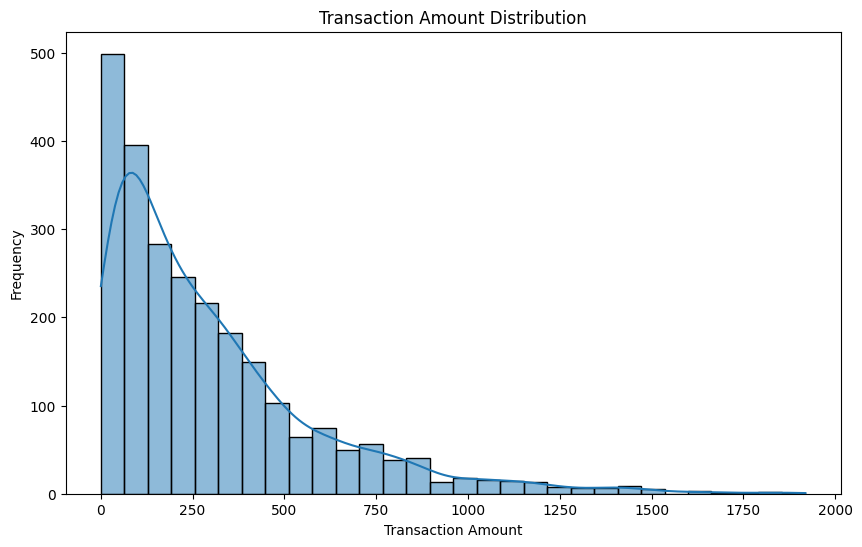

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Transaction Amount Distribution
plt.figure(figsize=(10, 6))
sns.histplot(data['TransactionAmount'], bins=30, kde=True)
plt.title("Transaction Amount Distribution")
plt.xlabel("Transaction Amount")
plt.ylabel("Frequency")
plt.show()



Transactions Type (Debit,Credit) With Number Of Counts/Occurences.

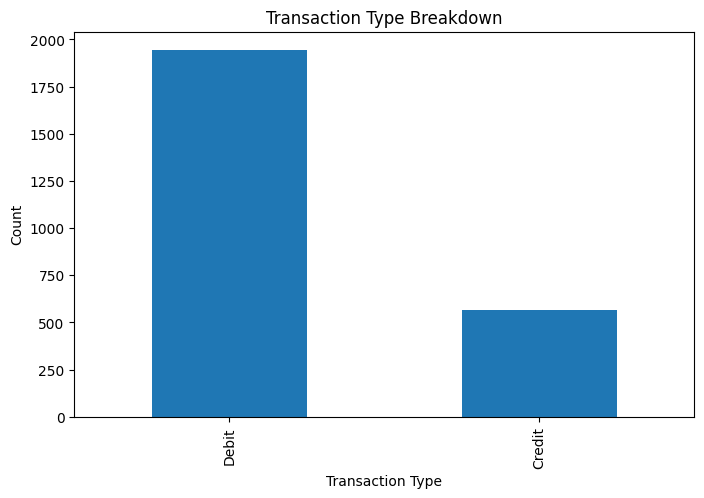

In [4]:
# 2. Transaction Type Breakdown
plt.figure(figsize=(8, 5))
data['TransactionType'].value_counts().plot(kind='bar')
plt.title("Transaction Type Breakdown")
plt.xlabel("Transaction Type")
plt.ylabel("Count")
plt.show()




Number Of Transactions Against Time-Period

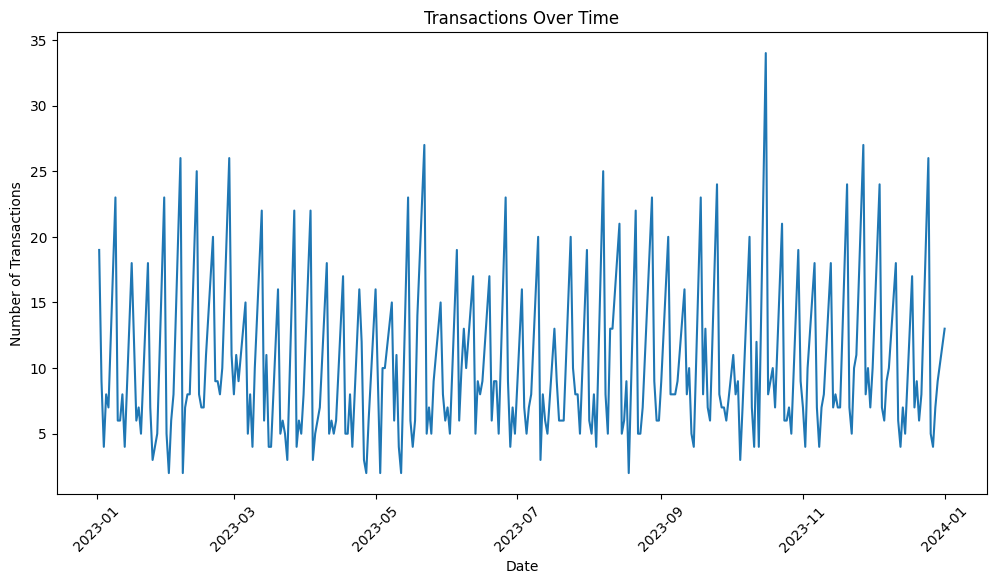

In [9]:
# 3. Transactions Over Time
plt.figure(figsize=(12, 6))
# Ensure 'TransactionDate' is of datetime type before using .dt
data['TransactionDate'] = pd.to_datetime(data['TransactionDate'])
data.groupby(data['TransactionDate'].dt.date).size().plot(kind='line')
plt.title("Transactions Over Time")
plt.xlabel("Date")
plt.ylabel("Number of Transactions")
plt.xticks(rotation=45)
plt.show()




Distribution For Mode Used For Transactions (Bank, ATM Or Online).

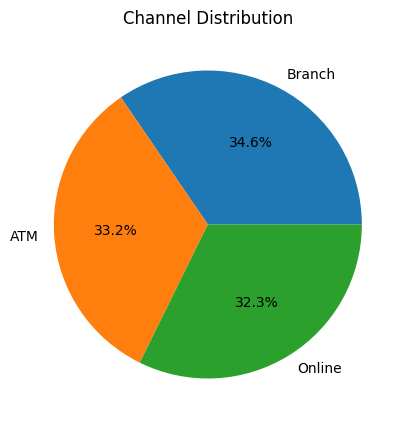

In [10]:
# 4. Channel Distribution
plt.figure(figsize=(8, 5))
data['Channel'].value_counts().plot(kind='pie', autopct='%1.1f%%')
plt.title("Channel Distribution")
plt.ylabel("")  # Hide y-label for pie chart
plt.show()



Transaction With Respect To Age Vs Number Of Counts/Occurences.

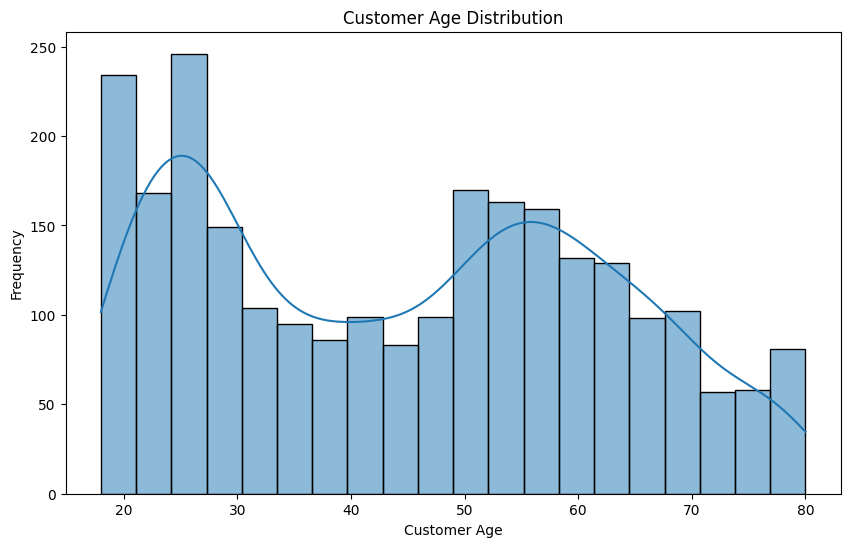

In [11]:
# 5. Customer Age Distribution
plt.figure(figsize=(10, 6))
sns.histplot(data['CustomerAge'], bins=20, kde=True)
plt.title("Customer Age Distribution")
plt.xlabel("Customer Age")
plt.ylabel("Frequency")
plt.show()



Displaying Transaction Amount Against Relevant Account Balance.

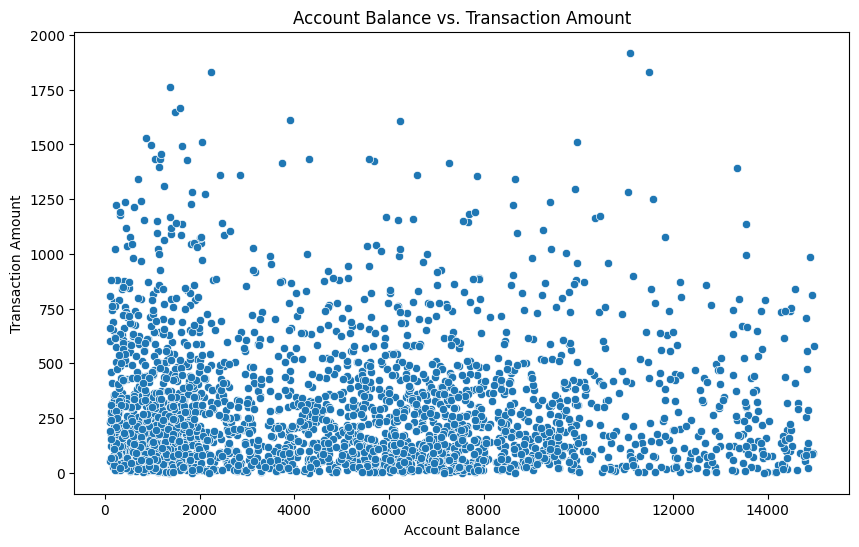

In [12]:
# 6. Account Balance vs. Transaction Amount
plt.figure(figsize=(10, 6))
sns.scatterplot(x='AccountBalance', y='TransactionAmount', data=data)
plt.title("Account Balance vs. Transaction Amount")
plt.xlabel("Account Balance")
plt.ylabel("Transaction Amount")
plt.show()



**FEATURE IMPORTANCE SCORE**

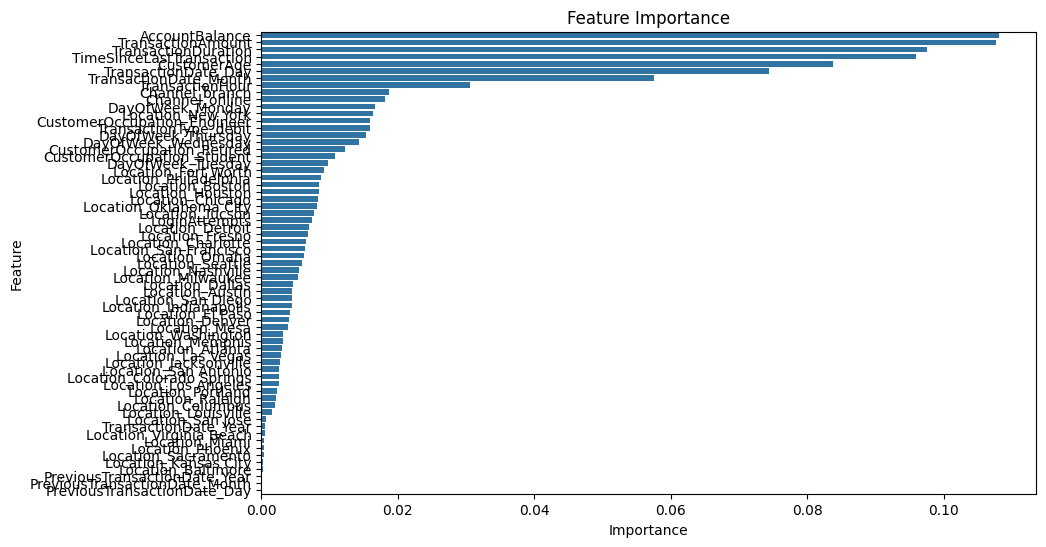

In [ ]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

# Drop irrelevant columns
irrelevant_cols = ['AccountID', 'DeviceID', 'IP Address', 'MerchantID']
data_cleaned = data.drop(columns=irrelevant_cols)

# Identify categorical columns
categorical_cols = ['TransactionType', 'Location', 'Channel', 'CustomerOccupation', 'DayOfWeek']

# Apply One-Hot Encoding to categorical columns
data_encoded = pd.get_dummies(data_cleaned, columns=categorical_cols, drop_first=True)

# Convert datetime columns to numerical features
# Extract numerical features from date columns
for col in ['TransactionDate', 'PreviousTransactionDate']:
    if col in data_encoded.columns:
        data_encoded[col + '_Year'] = data_encoded[col].dt.year
        data_encoded[col + '_Month'] = data_encoded[col].dt.month
        data_encoded[col + '_Day'] = data_encoded[col].dt.day
        # Drop the original datetime column
        data_encoded = data_encoded.drop(columns=[col])

# Check if target column 'Fraud' exists; simulate if not present
if 'Fraud' not in data_encoded.columns:
    import numpy as np
    # Simulate 'Fraud' column (replace with real labels in production)
    data_encoded['Fraud'] = np.random.choice([0, 1], size=len(data_encoded), p=[0.95, 0.05])

# Split features and target
X = data_encoded.drop('Fraud', axis=1)
y = data_encoded['Fraud']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Random Forest Classifier for feature importance
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

# Feature Importance
importances = rf_model.feature_importances_
features = X.columns
importance_df = pd.DataFrame({'Feature': features, 'Importance': importances}).sort_values(by='Importance', ascending=False)

# Plot Feature Importance
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title("Feature Importance")
plt.show()

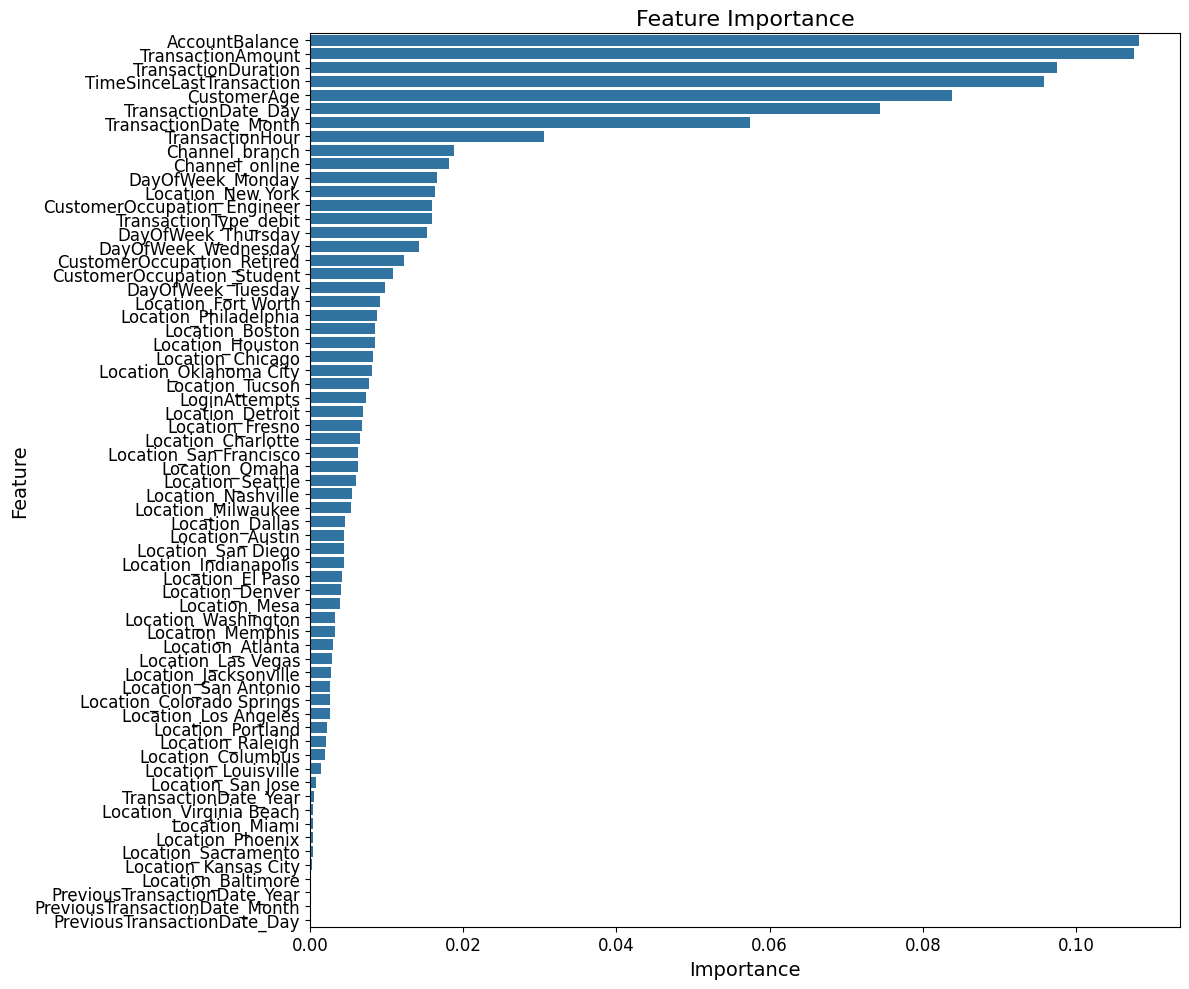

In [ ]:
plt.figure(figsize=(12, 10))  # Increase the size for better visibility
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title("Feature Importance", fontsize=16)
plt.xlabel("Importance", fontsize=14)
plt.ylabel("Feature", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()


**FEATURES SELECTION USING RECURSSIVE FEATURE ELIMINATION**

In [ ]:
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# Prepare the dataset
X = data_encoded.drop('Fraud', axis=1)
y = data_encoded['Fraud']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Use Random Forest as the base estimator
rf_model = RandomForestClassifier(random_state=42)

# Recursive Feature Elimination (RFE)
rfe = RFE(estimator=rf_model, n_features_to_select=10)  # Select the top 10 features
rfe.fit(X_train, y_train)

# Get the selected features
selected_features = X.columns[rfe.support_]
print("Selected Features:")
print(selected_features)

# Create a new dataset with only the selected features
X_train_refined = X_train[selected_features]
X_test_refined = X_test[selected_features]


Selected Features:
Index(['TransactionAmount', 'CustomerAge', 'TransactionDuration',
       'AccountBalance', 'TransactionHour', 'TimeSinceLastTransaction',
       'Channel_branch', 'DayOfWeek_Monday', 'TransactionDate_Month',
       'TransactionDate_Day'],
      dtype='object')


**DATA SPLITTING WITH ONLY SELECTED FEATURES**

In [ ]:
# Create a refined dataset with the selected features
X_refined = data_encoded[selected_features]
y = data_encoded['Fraud']  # Assuming 'Fraud' is the target column

# Train-test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_refined, y, test_size=0.2, random_state=42)


**RANDOM FOREST MODEL**

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score

# Train Random Forest model
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

# Make predictions
y_pred = rf_model.predict(X_test)
y_proba = rf_model.predict_proba(X_test)[:, 1]

# Evaluate the model
print("Classification Report:\n", classification_report(y_test, y_pred))
print("AUC-ROC Score:", roc_auc_score(y_test, y_proba))


Classification Report:
               precision    recall  f1-score   support

           0       0.96      1.00      0.98       483
           1       0.00      0.00      0.00        20

    accuracy                           0.96       503
   macro avg       0.48      0.50      0.49       503
weighted avg       0.92      0.96      0.94       503

AUC-ROC Score: 0.4230848861283644


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


**XGB GRADIENT BOOSTING MODEL**

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

# Train Gradient Boosting model
gb_model = GradientBoostingClassifier(random_state=42)
gb_model.fit(X_train, y_train)

# Make predictions
y_pred_gb = gb_model.predict(X_test)
y_proba_gb = gb_model.predict_proba(X_test)[:, 1]

# Evaluate the model
print("Classification Report:\n", classification_report(y_test, y_pred_gb))
print("AUC-ROC Score:", roc_auc_score(y_test, y_proba_gb))


Classification Report:
               precision    recall  f1-score   support

           0       0.96      1.00      0.98       483
           1       0.00      0.00      0.00        20

    accuracy                           0.96       503
   macro avg       0.48      0.50      0.49       503
weighted avg       0.92      0.96      0.94       503

AUC-ROC Score: 0.5043478260869565


**APPLYING SMOTE FOR WEIGHT CLASS BALANCE**

In [ ]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

# Apply SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_refined, y)

# Train-test split on balanced dataset
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)


In [ ]:
# Random Forest with class weight adjustment
rf_model = RandomForestClassifier(random_state=42, class_weight='balanced')
rf_model.fit(X_train, y_train)

# Gradient Boosting does not have a direct class_weight parameter,
# but you can modify the dataset as done above or tweak `learning_rate` and `max_depth`.


RandomForestClassifier(class_weight='balanced', random_state=42)

**XGBOOST GRADIENT MODEL**

In [ ]:
from xgboost import XGBClassifier

xgb_model = XGBClassifier(scale_pos_weight=len(y_train[y_train == 0]) / len(y_train[y_train == 1]))
xgb_model.fit(X_train, y_train)

# Evaluate XGBoost
y_pred_xgb = xgb_model.predict(X_test)
y_proba_xgb = xgb_model.predict_proba(X_test)[:, 1]
print("Classification Report:\n", classification_report(y_test, y_pred_xgb))
print("AUC-ROC Score:", roc_auc_score(y_test, y_proba_xgb))


Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.90      0.94       493
           1       0.91      0.98      0.94       467

    accuracy                           0.94       960
   macro avg       0.94      0.94      0.94       960
weighted avg       0.94      0.94      0.94       960

AUC-ROC Score: 0.9816923003418306
